In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/foodcom-recipes-and-reviews/recipes.parquet
/kaggle/input/foodcom-recipes-and-reviews/reviews.parquet
/kaggle/input/foodcom-recipes-and-reviews/reviews.csv
/kaggle/input/foodcom-recipes-and-reviews/recipes.csv


Datasetleri okutalım;

In [2]:
import re
import pylab 
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate

pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
def load():
    data = pd.read_csv("/kaggle/input/foodcom-recipes-and-reviews/recipes.csv")
    return data

df = load()
df.head()

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",Frozen Desserts,"c(""Dessert"", ""Low Protein"", ""Low Cholesterol"",...","c(""4"", ""1/4"", ""1"", ""1"")","c(""blueberries"", ""granulated sugar"", ""vanilla ...",4.500,4.000,170.900,2.500,1.300,8.000,29.800,37.100,3.600,30.200,3.200,4.000,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",Chicken Breast,"c(""Chicken Thigh & Leg"", ""Chicken"", ""Poultry"",...","c(""1"", ""4"", ""2"", ""2"", ""8"", ""1/4"", ""8"", ""1/2"", ...","c(""saffron"", ""milk"", ""hot green chili peppers""...",3.000,1.000,1110.700,58.800,16.600,372.800,368.400,84.400,9.000,20.400,63.400,6.000,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",Beverages,"c(""Low Protein"", ""Low Cholesterol"", ""Healthy"",...","c(""1 1/2"", ""1"", NA, ""1 1/2"", NA, ""3/4"")","c(""sugar"", ""lemons, rind of"", ""lemon, zest of""...",4.500,10.000,311.100,0.200,0.000,0.000,1.800,81.500,0.400,77.200,0.300,4.000,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",Soy/Tofu,"c(""Beans"", ""Vegetable"", ""Low Cholesterol"", ""We...","c(""12"", ""1"", ""2"", ""1"", ""10"", ""1"", ""3"", ""2"", ""2...","c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...",4.500,2.000,536.100,24.000,3.800,0.000,1558.600,64.200,17.300,32.100,29.300,2.000,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc..."
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",Vegetable,"c(""Low Protein"", ""Vegan"", ""Low Cholesterol"", ""...","c(""46"", ""4"", ""1"", ""2"", ""1"")","c(""plain tomato juice"", ""cabbage"", ""onion"", ""c...",4.500,11.000,103.600,0.400,0.100,0.000,959.300,25.100,4.800,17.700,4.300,4.000,NaN,"c(""Mix everything together and bring to a boil..."


EDA

In [4]:
# Ayarlar
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)

# Verileri yükle
recipes = pd.read_csv("/kaggle/input/foodcom-recipes-and-reviews/recipes.csv")
reviews = pd.read_csv("/kaggle/input/foodcom-recipes-and-reviews/reviews.csv")

# --- Recipes Dataset ---
print("🔹 Tarif Verisi:")
print(recipes.info())
print(recipes.describe())
print("\nEksik veri kontrolü:")
print(recipes.isnull().sum())

# --- Reviews Dataset ---
print("\n🔹 İnceleme Verisi:")
print(reviews.info())
print(reviews.describe())
print("\nEksik veri kontrolü:")
print(reviews.isnull().sum())

🔹 Tarif Verisi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    522517 non-null  int64  
 1   Name                        522517 non-null  object 
 2   AuthorId                    522517 non-null  int64  
 3   AuthorName                  522517 non-null  object 
 4   CookTime                    439972 non-null  object 
 5   PrepTime                    522517 non-null  object 
 6   TotalTime                   522517 non-null  object 
 7   DatePublished               522517 non-null  object 
 8   Description                 522512 non-null  object 
 9   Images                      522516 non-null  object 
 10  RecipeCategory              521766 non-null  object 
 11  Keywords                    505280 non-null  object 
 12  RecipeIngredientQuantities  522514 non-null  object 
 13

🔹 recipes (Tarifler)
Gözlem	Detay
🔢 Satır sayısı = 	522,517 tarif — çok büyük ve zengin veri!
🧂 Malzeme & Talimatlar = RecipeIngredientParts ve RecipeInstructions eksiksiz. Ana analiz buradan yapılabilir.
📈 Puanlar = AggregatedRating yalnızca ~269K tarifte mevcut → bu alan sparse (seyrek)
⚠️ Eksik alanlar = CookTime, RecipeYield, RecipeServings gibi alanlar önemli ölçüde eksik
🧪 Besin değerleri = Tam veri var ama uç değerler çok yüksek — potansiyel outlier temizliği gerekebilir

🔹 reviews (Yorumlar)
Gözlem	Detay
🔢 Satır sayısı = 1.4 milyon yorum var — öneri sistemleri için çok faydalı
⭐ Ortalama Puan = Ortalama rating ≈ 4.4, sağa çarpık bir dağılım (çoğu yüksek puan)
📝 Eksik veri = Review alanında sadece 214 eksik — ihmal edilebilir düzeyde

In [5]:
recipes = recipes.copy()

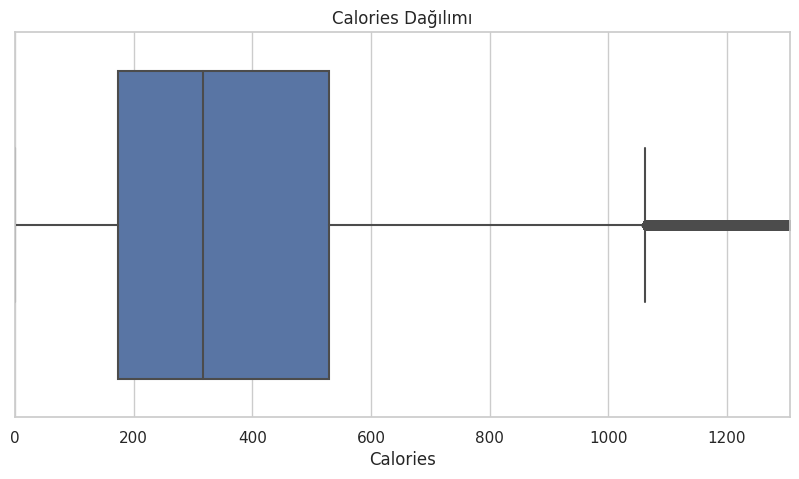

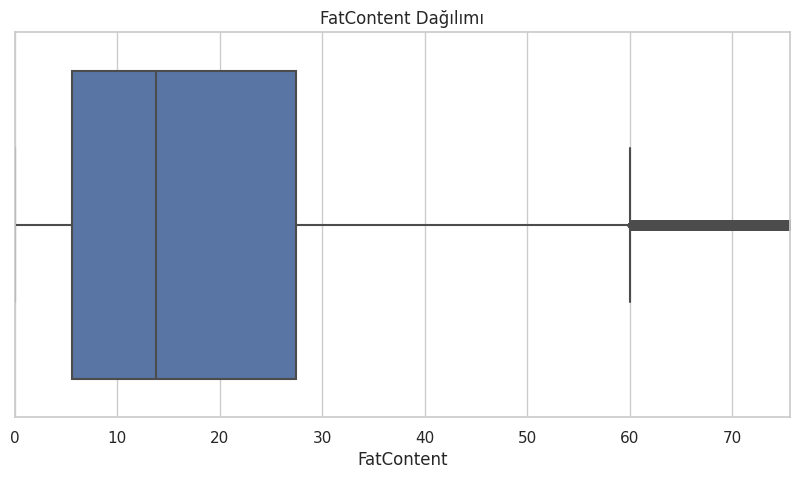

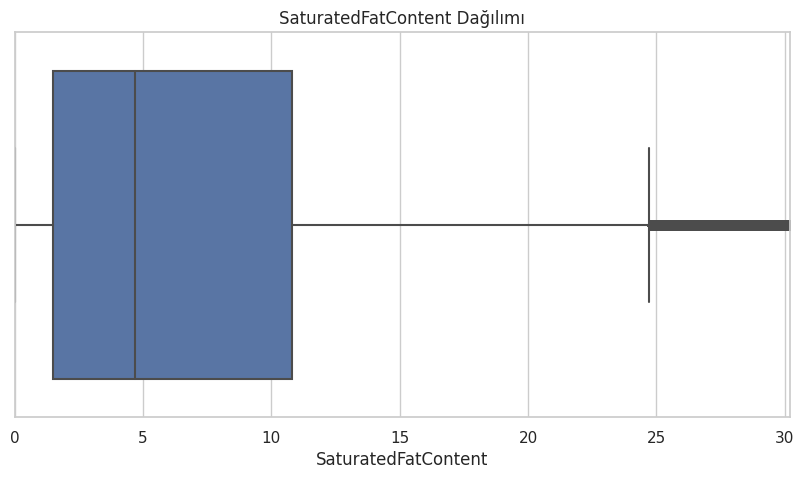

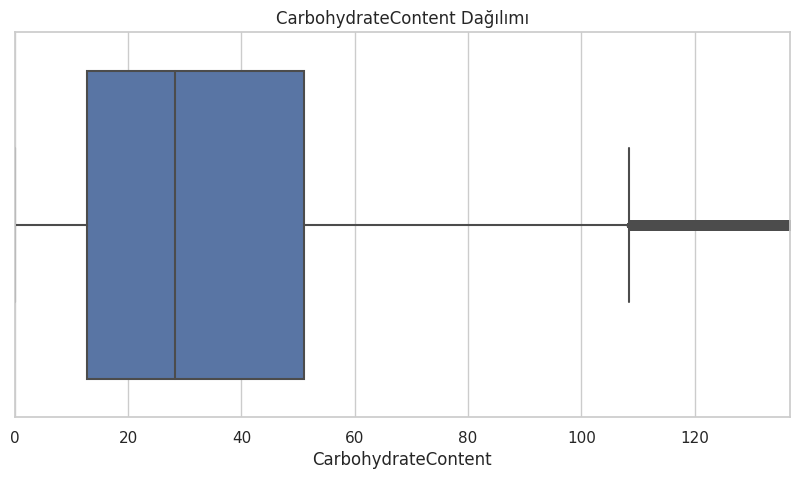

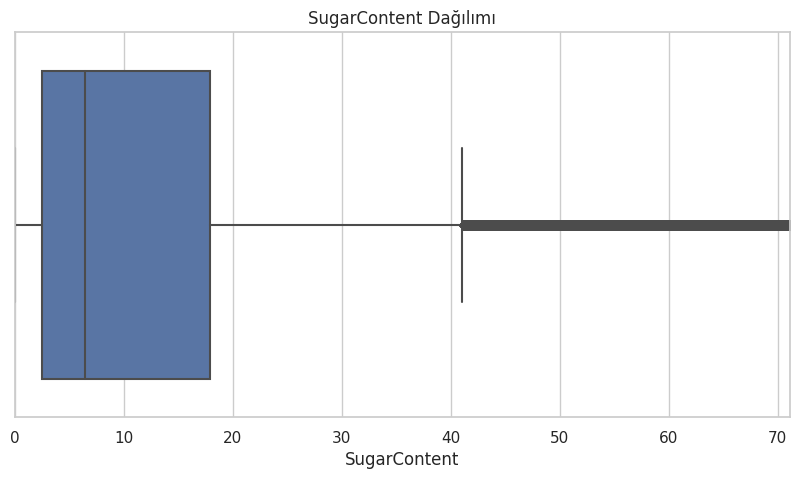

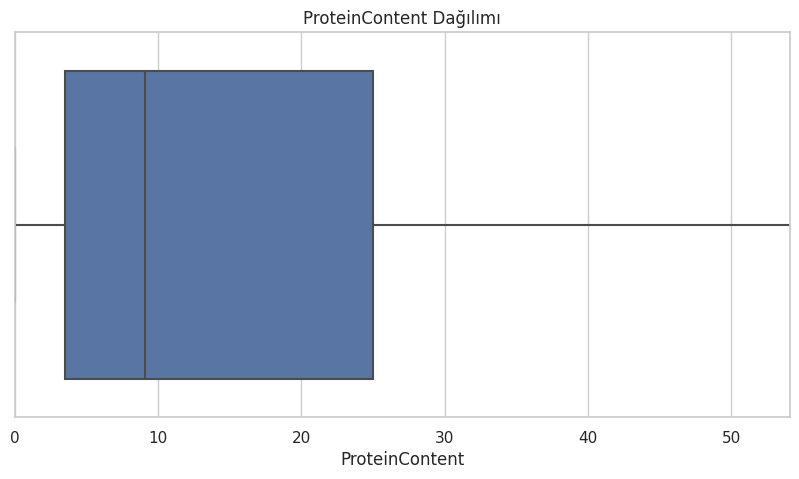

In [6]:
# Besin değerleri için boxplot (aşırı uçları incele)
nutrients = ['Calories', 'FatContent', 'SaturatedFatContent', 'CarbohydrateContent', 'SugarContent', 'ProteinContent']

for col in nutrients:
    sns.boxplot(x=recipes[col])
    plt.title(f"{col} Dağılımı")
    plt.xlim(0, recipes[col].quantile(0.95))  # uç değerleri kırpmak için
    plt.show()

****Aykırı Değer Analizi****

In [7]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    outliers = dataframe[(dataframe[col_name] < low) | (dataframe[col_name] > up)]

    print(outliers.head() if len(outliers) > 10 else outliers)

    if index:
        return outliers.index

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [8]:
for col in nutrients:
    print(col, check_outlier(recipes, col))
for col in nutrients:
    print(col, grab_outliers(recipes, col))
#check_outlier()
#grab_outliers()
#replace_with_thresholds()

Calories True
FatContent True
SaturatedFatContent True
CarbohydrateContent True
SugarContent True
ProteinContent True
    RecipeId                Name  AuthorId           AuthorName CookTime PrepTime TotalTime         DatePublished                                        Description                                             Images  RecipeCategory                                           Keywords                         RecipeIngredientQuantities                              RecipeIngredientParts  AggregatedRating  ReviewCount  Calories  FatContent  SaturatedFatContent  CholesterolContent  SodiumContent  \
1         39             Biryani      1567             elly9812    PT25M     PT4H   PT4H25M  1999-08-29T13:12:00Z  Make and share this Biryani recipe from Food.com.  c("https://img.sndimg.com/food/image/upload/w_...  Chicken Breast  c("Chicken Thigh & Leg", "Chicken", "Poultry",...  c("1", "4", "2", "2", "8", "1/4", "8", "1/2", ...  c("saffron", "milk", "hot green chili peppers"... 

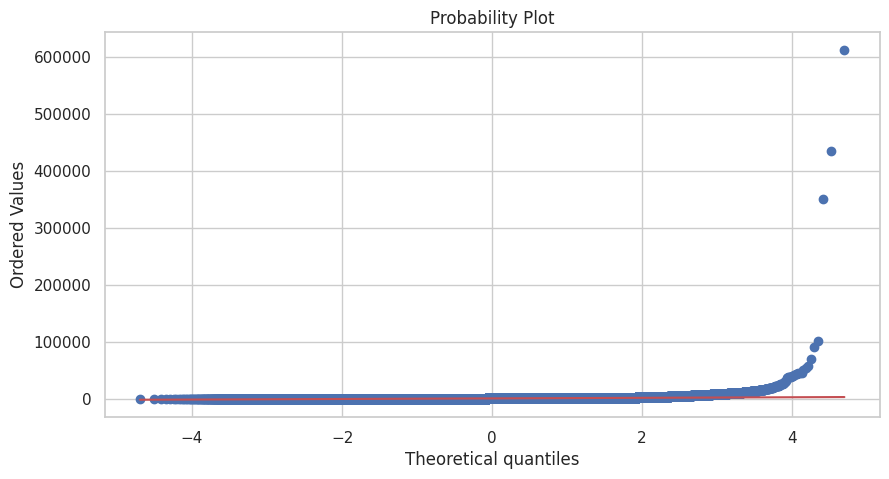

In [9]:
stats.probplot(recipes.Calories.to_numpy(), dist="norm", plot=pylab)
pylab.show()

In [10]:
recipes_1=recipes.copy()

Bir değişkende aykırı değer baskılama test edelim;

In [11]:
col = "Calories"

# 1. Aykırı değer var mı?
print("Aykırı değer var mı:", check_outlier(recipes_1, col))

# 2. Aykırı değerleri göster
print("İlk birkaç aykırı değer:")
grab_outliers(recipes_1, col)

# 3. İşlem öncesi istatistikler
print("\nÖnce - max:", recipes_1[col].max())

# 4. Winsorize et
replace_with_thresholds(recipes_1, col)

# 5. İşlem sonrası istatistik
print("Sonra - max:", recipes_1[col].max())

Aykırı değer var mı: True
İlk birkaç aykırı değer:
    RecipeId                Name  AuthorId           AuthorName CookTime PrepTime TotalTime         DatePublished                                        Description                                             Images  RecipeCategory                                           Keywords                         RecipeIngredientQuantities                              RecipeIngredientParts  AggregatedRating  ReviewCount  Calories  FatContent  SaturatedFatContent  CholesterolContent  SodiumContent  \
1         39             Biryani      1567             elly9812    PT25M     PT4H   PT4H25M  1999-08-29T13:12:00Z  Make and share this Biryani recipe from Food.com.  c("https://img.sndimg.com/food/image/upload/w_...  Chicken Breast  c("Chicken Thigh & Leg", "Chicken", "Poultry",...  c("1", "4", "2", "2", "8", "1/4", "8", "1/2", ...  c("saffron", "milk", "hot green chili peppers"...             3.000        1.000  1110.700      58.800               

In [12]:
outlier_cols = [
    "FatContent", 
    "RecipeServings", 
    "ReviewCount",
    "Calories",
    "SodiumContent",
    "CholesterolContent",
    "ProteinContent",
    "SaturatedFatContent",
    "CarbohydrateContent",
    "SugarContent",
    "FiberContent"
]

for col in outlier_cols:
    if check_outlier(recipes_1, col):
        print(f"{col}: Aykırı değerler bulundu, eşiklerle değiştiriliyor...")
        replace_with_thresholds(recipes_1, col)
    else:
        print(f"{col}: Aykırı değer yok.")

FatContent: Aykırı değerler bulundu, eşiklerle değiştiriliyor...
RecipeServings: Aykırı değerler bulundu, eşiklerle değiştiriliyor...


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


ReviewCount: Aykırı değerler bulundu, eşiklerle değiştiriliyor...
Calories: Aykırı değer yok.
SodiumContent: Aykırı değerler bulundu, eşiklerle değiştiriliyor...


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


CholesterolContent: Aykırı değerler bulundu, eşiklerle değiştiriliyor...
ProteinContent: Aykırı değerler bulundu, eşiklerle değiştiriliyor...
SaturatedFatContent: Aykırı değerler bulundu, eşiklerle değiştiriliyor...
CarbohydrateContent: Aykırı değerler bulundu, eşiklerle değiştiriliyor...
SugarContent: Aykırı değerler bulundu, eşiklerle değiştiriliyor...
FiberContent: Aykırı değerler bulundu, eşiklerle değiştiriliyor...


Tekrar aykırı değer kontrolü yapıp işlemlerin başarısını analiz edelim:

In [13]:
recipes_2 = recipes_1.copy()

In [14]:
# --- Recipes Dataset ---
print("🔹 Tarif Verisi:")
print(recipes_2.describe())

🔹 Tarif Verisi:
        RecipeId       AuthorId  AggregatedRating  ReviewCount   Calories  FatContent  SaturatedFatContent  CholesterolContent  SodiumContent  CarbohydrateContent  FiberContent  SugarContent  ProteinContent  RecipeServings
count 522517.000     522517.000        269294.000   275028.000 522517.000  522517.000           522517.000          522517.000     522517.000           522517.000    522517.000    522517.000      522517.000      339606.000
mean  271821.437   45725847.894             4.632        3.121    390.642      19.094                7.302              70.503        540.976               36.406         3.168        12.264          15.876           6.623
std   155495.878  292971448.666             0.642        2.580    285.652      17.470                7.396              78.657        533.174               30.347         3.032        13.232          16.048           3.827
min       38.000         27.000             1.000        1.000      0.000       0.000       

Eksik değer analizine geçelim;

In [15]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

missing_values_table(recipes_2, True)
missing_values_table(reviews, True)

                            n_miss  ratio
RecipeYield                 348071 66.610
AggregatedRating            253223 48.460
ReviewCount                 247489 47.360
RecipeServings              182911 35.010
CookTime                     82545 15.800
Keywords                     17237  3.300
RecipeCategory                 751  0.140
Description                      5  0.000
RecipeIngredientQuantities       3  0.000
Images                           1  0.000
        n_miss  ratio
Review     214  0.020


['Review']

CookTime, PrepTime, TotalTime formatı date'e dönüştürülmeli

In [16]:
def parse_duration(duration_str):
    if not isinstance(duration_str, str) or not duration_str.startswith("PT"):
        return None  # geçersiz veya boşsa

    hours = minutes = 0

    match_hours = re.search(r"(\d+)H", duration_str)
    match_minutes = re.search(r"(\d+)M", duration_str)

    if match_hours:
        hours = int(match_hours.group(1))
    if match_minutes:
        minutes = int(match_minutes.group(1))

    return hours * 60 + minutes

In [17]:
# PT formatlarını dakikaya çevir
recipes_2["CookTime_min"] = recipes_2["CookTime"].apply(parse_duration)
recipes_2["PrepTime_min"] = recipes_2["PrepTime"].apply(parse_duration)
recipes_2["TotalTime_min"] = recipes_2["TotalTime"].apply(parse_duration)

# Eksik CookTime'ları hesapla: Cook = Total - Prep
missing_cook = recipes_2["CookTime_min"].isnull()
recipes_2.loc[missing_cook, "CookTime_min"] = (
    recipes_2["TotalTime_min"] - recipes_2["PrepTime_min"]
)[missing_cook]

# Negatif değerleri sıfıra eşitle
recipes_2["CookTime_min"] = recipes_2["CookTime_min"].apply(lambda x: max(x, 0) if not pd.isnull(x) else x)

# Eski string formatlı sütunlar istersen silinebilir:
# recipes.drop(columns=["CookTime", "PrepTime", "TotalTime"], inplace=True) SİLELİM Mİ? 

# Yeni sütunları yeniden adlandır
recipes_2.rename(columns={
    "CookTime_min": "CookTime(min)",
    "PrepTime_min": "PrepTime(min)",
    "TotalTime_min": "TotalTime(min)"
}, inplace=True)

In [18]:
recipes_3 = recipes_2.copy()

In [19]:
recipes_3.head()

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,CookTime(min),PrepTime(min),TotalTime(min)
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",Frozen Desserts,"c(""Dessert"", ""Low Protein"", ""Low Cholesterol"",...","c(""4"", ""1/4"", ""1"", ""1"")","c(""blueberries"", ""granulated sugar"", ""vanilla ...",4.500,4.000,170.900,2.500,1.300,8.000,29.800,37.100,3.600,30.200,3.200,4.000,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan...",1440.000,45,1485
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",Chicken Breast,"c(""Chicken Thigh & Leg"", ""Chicken"", ""Poultry"",...","c(""1"", ""4"", ""2"", ""2"", ""8"", ""1/4"", ""8"", ""1/2"", ...","c(""saffron"", ""milk"", ""hot green chili peppers""...",3.000,1.000,1061.450,58.800,16.600,264.050,368.400,84.400,9.000,20.400,57.250,6.000,NaN,"c(""Soak saffron in warm milk for 5 minutes and...",25.000,240,265
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",Beverages,"c(""Low Protein"", ""Low Cholesterol"", ""Healthy"",...","c(""1 1/2"", ""1"", NA, ""1 1/2"", NA, ""3/4"")","c(""sugar"", ""lemons, rind of"", ""lemon, zest of""...",4.500,8.500,311.100,0.200,0.000,0.000,1.800,81.500,0.400,41.000,0.300,4.000,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ...",5.000,30,35
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",Soy/Tofu,"c(""Beans"", ""Vegetable"", ""Low Cholesterol"", ""We...","c(""12"", ""1"", ""2"", ""1"", ""10"", ""1"", ""3"", ""2"", ""2...","c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...",4.500,2.000,536.100,24.000,3.800,0.000,1558.600,64.200,10.300,32.100,29.300,2.000,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc...",20.000,1440,1460
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",Vegetable,"c(""Low Protein"", ""Vegan"", ""Low Cholesterol"", ""...","c(""46"", ""4"", ""1"", ""2"", ""1"")","c(""plain tomato juice"", ""cabbage"", ""onion"", ""c...",4.500,8.500,103.600,0.400,0.100,0.000,959.300,25.100,4.800,17.700,4.300,4.000,NaN,"c(""Mix everything together and bring to a boil...",30.000,20,50


In [20]:
missing_values_table(recipes_3, True)

                            n_miss  ratio
RecipeYield                 348071 66.610
AggregatedRating            253223 48.460
ReviewCount                 247489 47.360
RecipeServings              182911 35.010
CookTime                     82545 15.800
Keywords                     17237  3.300
RecipeCategory                 751  0.140
Description                      5  0.000
RecipeIngredientQuantities       3  0.000
Images                           1  0.000


['CookTime',
 'Description',
 'Images',
 'RecipeCategory',
 'Keywords',
 'RecipeIngredientQuantities',
 'AggregatedRating',
 'ReviewCount',
 'RecipeServings',
 'RecipeYield']

In [21]:
recipes_3.drop("RecipeYield", axis=1, inplace=True)

In [22]:
recipes_3["RecipeServings"].fillna(recipes_3["RecipeServings"].median(), inplace=True)

<ipython-input-22-4d6780ac2719>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  recipes_3["RecipeServings"].fillna(recipes_3["RecipeServings"].median(), inplace=True)


In [23]:
missing_values_table(recipes_3, True)

                            n_miss  ratio
AggregatedRating            253223 48.460
ReviewCount                 247489 47.360
CookTime                     82545 15.800
Keywords                     17237  3.300
RecipeCategory                 751  0.140
Description                      5  0.000
RecipeIngredientQuantities       3  0.000
Images                           1  0.000


['CookTime',
 'Description',
 'Images',
 'RecipeCategory',
 'Keywords',
 'RecipeIngredientQuantities',
 'AggregatedRating',
 'ReviewCount']

In [24]:
recipes_3["Keywords"].fillna("", inplace=True)
recipes_3["RecipeCategory"].fillna("Unknown", inplace=True)
recipes_3["Description"].fillna("", inplace=True)

<ipython-input-24-ea8ff1661769>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  recipes_3["Keywords"].fillna("", inplace=True)
<ipython-input-24-ea8ff1661769>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

Images sütunu boş olan bir satır var. Bu satıra manuel link koyalım.

In [25]:
recipes[recipes["Images"].isnull()]

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
3645,5428,Hot Swiss Chard Salad,1534,Tonkcats,NaN,PT0S,PT0S,1999-12-15T23:37:00Z,NaN,NaN,Swiss,"c(""European"", ""Very Low Carbs"", ""< 15 Mins"")","c(""1"", ""1/3"", ""10 -12"", ""1/4"", ""1/4"", NA, ""2"",...","c(""garlic"", ""fresh swiss chard"", ""red wine vin...",5.000,5.000,928.600,93.000,15.900,344.600,1172.600,7.200,2.100,2.500,16.400,1.000,NaN,"c(""Marinate garlic clove in oil for 1 hour."", ..."


In [26]:
# Önerilen genel amaçlı placeholder görsel URL'si (örnek):
placeholder_url = "https://evergreenkitchen.ca/wp-content/uploads/2024/07/Swiss-Chard-Salad-Evergreen-Kitchen-1.jpg"
recipes_3["Images"].fillna(placeholder_url, inplace=True)

<ipython-input-26-83b46d348432>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  recipes_3["Images"].fillna(placeholder_url, inplace=True)


In [27]:
missing_values_table(recipes_3, True)

                            n_miss  ratio
AggregatedRating            253223 48.460
ReviewCount                 247489 47.360
CookTime                     82545 15.800
RecipeIngredientQuantities       3  0.000


['CookTime', 'RecipeIngredientQuantities', 'AggregatedRating', 'ReviewCount']

In [28]:
recipes_4 = recipes_3.copy()

CookTime , PrepTime ve TotalTime kolonlarındaki ifadeleri dakika cinsinden ifade eden CookTime(min) , TotalTime(min) ve PrepTime(min) kolonlarını oluşturduğumuz için CookTime , PrepTime ve TotalTime kolonlarını sildik

In [29]:
recipes_4.drop(["CookTime", "PrepTime", "TotalTime"], axis=1, inplace=True)

"DatePublished" kolonunu datetime e çevirelim

In [30]:
recipes_4["DatePublished"] = pd.to_datetime(recipes_4["DatePublished"], utc=True)
recipes_4["year"] = recipes_4["DatePublished"].dt.year
recipes_4["month"] = recipes_4["DatePublished"].dt.month
recipes_4["day"] = recipes_4["DatePublished"].dt.day

recipes_4["DatePublished"] = pd.to_datetime(recipes_4[['year', 'month', 'day']])

In [31]:
recipes_4.drop(['year', 'month', 'day'], axis= 1, inplace = True)

In [32]:
recipes_5 = recipes_4.copy()

In [33]:
missing_values_table(recipes_5, True)

                            n_miss  ratio
AggregatedRating            253223 48.460
ReviewCount                 247489 47.360
RecipeIngredientQuantities       3  0.000


['RecipeIngredientQuantities', 'AggregatedRating', 'ReviewCount']

In [34]:
recipes_5[recipes_5["RecipeIngredientQuantities"].isnull()]

,RecipeId,Name,AuthorId,AuthorName,DatePublished,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,CookTime(min),PrepTime(min),TotalTime(min)
725,1068,Roasting Peppers,1702,Alison Corfield,1999-08-17,Make and share this Roasting Peppers recipe fr...,character(0),Peppers,"c(""Vegetable"", ""Very Low Carbs"", ""Low Protein""...",NaN,"""pepper""",4.500,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,"c(""I put them under a hot grill and turn them ...",0.000,0,0
6889,10007,Lemon Zest,9133,Cyberspace Monkey,2001-07-05,Make and share this Lemon Zest recipe from Foo...,character(0),Very Low Carbs,"c(""Low Protein"", ""Low Cholesterol"", ""< 15 Mins...",NaN,"""lemon""",5.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,6.000,"c(""take the zest (peel) from lemons with a zes...",0.000,5,5
448936,465556,Breading Deb Style,2025159,RDLundin,2011-10-05,Make and share this Breading Deb Style recipe ...,character(0),Very Low Carbs,"c(""Low Protein"", ""Low Cholesterol"", ""< 15 Mins...",NaN,character(0),NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,6.000,"""Crush these up til fine crumbs. Bread your s...",0.000,2,2


RecipeIngredientQuantities kolonunda sadece 3 satırda boş değer bulunmakta, közlenmiş biber, limon kabuğu ve bred tarzı ekmek sütunlarını silelim

In [35]:
recipes_5 = recipes_5.dropna(subset=["RecipeIngredientQuantities"])

In [36]:
missing_values_table(recipes_5, True)

                  n_miss  ratio
AggregatedRating  253222 48.460
ReviewCount       247488 47.360


['AggregatedRating', 'ReviewCount']

In [37]:
recipes_5["AggregatedRating"].describe([0.01, 0.05,0.40,0.75, 0.90, 0.99]).T

count   269292.000
mean         4.632
std          0.642
min          1.000
1%           2.000
5%           3.000
40%          5.000
50%          5.000
75%          5.000
90%          5.000
99%          5.000
max          5.000
Name: AggregatedRating, dtype: float64

In [38]:
recipes_5["ReviewCount"].describe([0.01, 0.05,0.40,0.75, 0.90, 0.99]).T

count   275026.000
mean         3.121
std          2.580
min          1.000
1%           1.000
5%           1.000
40%          2.000
50%          2.000
75%          4.000
90%          8.500
99%          8.500
max          8.500
Name: ReviewCount, dtype: float64

AggregatedRating ve ReviewCount kolonundaki çarpık oldukları için eksik değerleri medayan ile doldurmayı tercih ettik.

In [39]:
recipes_5['AggregatedRating'].fillna(5, inplace=True)

<ipython-input-39-729f038e1636>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  recipes_5['AggregatedRating'].fillna(5, inplace=True)


In [40]:
recipes_5['ReviewCount'].fillna(2, inplace=True)

<ipython-input-40-316dc562ca88>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  recipes_5['ReviewCount'].fillna(2, inplace=True)


In [41]:
missing_values_table(recipes_5, True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


[]

CookTime(min), PrepTime(min) ve TotalTime(min) değerleri için uç değerleri inceleme

In [42]:
recipes_5.head()

,RecipeId,Name,AuthorId,AuthorName,DatePublished,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,CookTime(min),PrepTime(min),TotalTime(min)
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,1999-08-09,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",Frozen Desserts,"c(""Dessert"", ""Low Protein"", ""Low Cholesterol"",...","c(""4"", ""1/4"", ""1"", ""1"")","c(""blueberries"", ""granulated sugar"", ""vanilla ...",4.500,4.000,170.900,2.500,1.300,8.000,29.800,37.100,3.600,30.200,3.200,4.000,"c(""Toss 2 cups berries with sugar."", ""Let stan...",1440.000,45,1485
1,39,Biryani,1567,elly9812,1999-08-29,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",Chicken Breast,"c(""Chicken Thigh & Leg"", ""Chicken"", ""Poultry"",...","c(""1"", ""4"", ""2"", ""2"", ""8"", ""1/4"", ""8"", ""1/2"", ...","c(""saffron"", ""milk"", ""hot green chili peppers""...",3.000,1.000,1061.450,58.800,16.600,264.050,368.400,84.400,9.000,20.400,57.250,6.000,"c(""Soak saffron in warm milk for 5 minutes and...",25.000,240,265
2,40,Best Lemonade,1566,Stephen Little,1999-09-05,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",Beverages,"c(""Low Protein"", ""Low Cholesterol"", ""Healthy"",...","c(""1 1/2"", ""1"", NA, ""1 1/2"", NA, ""3/4"")","c(""sugar"", ""lemons, rind of"", ""lemon, zest of""...",4.500,8.500,311.100,0.200,0.000,0.000,1.800,81.500,0.400,41.000,0.300,4.000,"c(""Into a 1 quart Jar with tight fitting lid, ...",5.000,30,35
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,1999-09-03,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",Soy/Tofu,"c(""Beans"", ""Vegetable"", ""Low Cholesterol"", ""We...","c(""12"", ""1"", ""2"", ""1"", ""10"", ""1"", ""3"", ""2"", ""2...","c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...",4.500,2.000,536.100,24.000,3.800,0.000,1558.600,64.200,10.300,32.100,29.300,2.000,"c(""Drain the tofu, carefully squeezing out exc...",20.000,1440,1460
4,42,Cabbage Soup,1538,Duckie067,1999-09-19,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",Vegetable,"c(""Low Protein"", ""Vegan"", ""Low Cholesterol"", ""...","c(""46"", ""4"", ""1"", ""2"", ""1"")","c(""plain tomato juice"", ""cabbage"", ""onion"", ""c...",4.500,8.500,103.600,0.400,0.100,0.000,959.300,25.100,4.800,17.700,4.300,4.000,"c(""Mix everything together and bring to a boil...",30.000,20,50


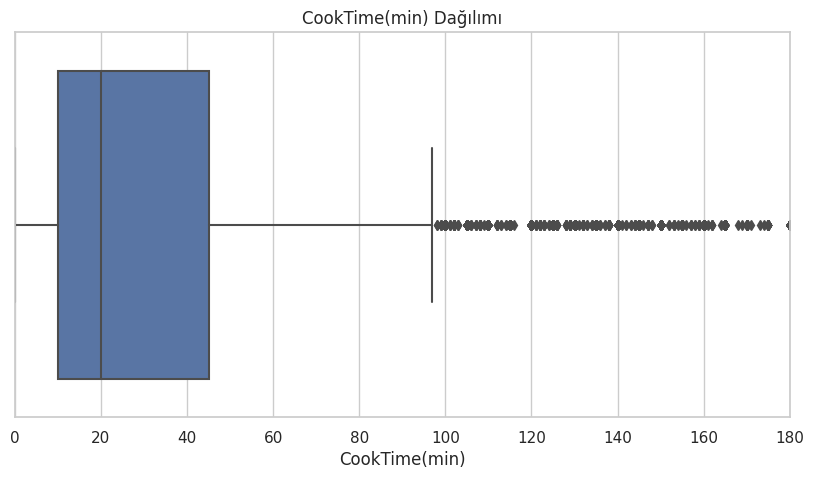

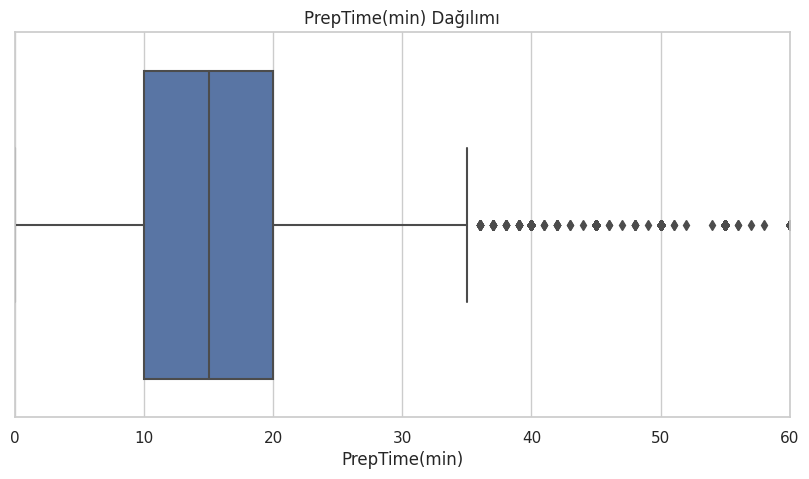

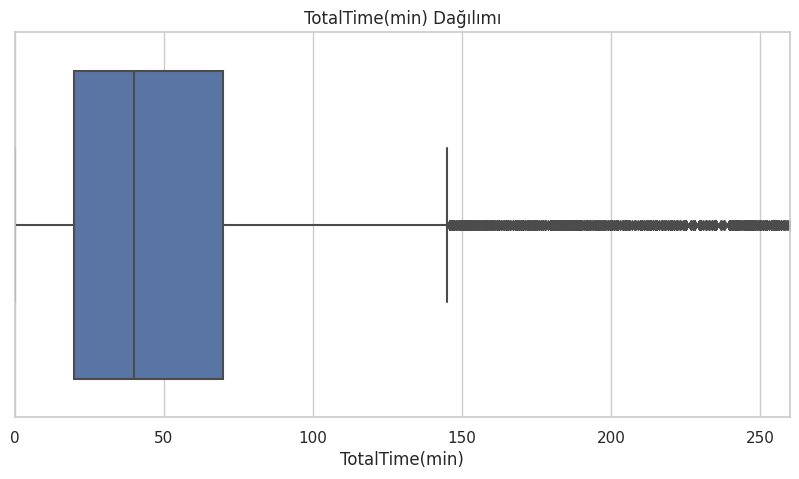

In [43]:
time_periods = [col for col in recipes_5.columns if "Time" in col]

for col in time_periods:
    sns.boxplot(x=recipes_5[col])
    plt.title(f"{col} Dağılımı")
    plt.xlim(0, recipes_5[col].quantile(0.95))  # uç değerleri kırpmak için
    plt.show()

CookTime(min), PrepTime(min) ve TotalTime(min) yüzde kaçı aykırı değerden oluşmakta kontrol ettik

In [44]:
for col in time_periods:
    Q1 = recipes_5[col].quantile(0.05)
    Q3 = recipes_5[col].quantile(0.95)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = recipes_5[(recipes_5[col] < lower_bound) | (recipes_5[col] > upper_bound)]
    
    outliers_count = outliers.shape[0]
    total_count = recipes_5.shape[0]
    
    outliers_percentage = (outliers_count / total_count) * 100
    
    print(f"{col} sütununda {outliers_count} adet ({outliers_percentage:.2f}%) aykırı değer var.")

CookTime(min) sütununda 9521 adet (1.82%) aykırı değer var.
PrepTime(min) sütununda 10219 adet (1.96%) aykırı değer var.
TotalTime(min) sütununda 7574 adet (1.45%) aykırı değer var.


Aykırı değerleri veri yapısının bozulmaması için uçlardan az bir baskılama yaptık

In [45]:
recipes_6 = recipes_5.copy()

In [46]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1, q3)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [47]:
for col in time_periods:
    replace_with_thresholds(recipes_6, col)

<ipython-input-46-baf870521c14>:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-82.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
<ipython-input-46-baf870521c14>:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-377.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit


İşlemi kontrol ettik

In [48]:
check_outlier(recipes_6, time_periods)

<ipython-input-7-d05119b0f637>:11: FutureWarning: 'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != pd.Timestamp(0)).any() instead.
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):


False

In [49]:
recipes_6["RecipeIngredientQuantities"].value_counts().head(10)

RecipeIngredientQuantities
c("1", "1", "1")                   955
c("1", "1")                        872
c("1", "1", "1", "1")              770
c("1", "1", "1", "1", "1")         569
c("1", "1", "1", "1", "1", "1")    265
c("2", "1", "1")                   263
c("1", NA)                         253
c("1", "2", "1")                   242
c("2", "1")                        239
c("2", "1", "1", "1")              232
Name: count, dtype: int64

In [50]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(recipes_6)

print("Categorical column names: {}".format(cat_cols))
print("Numerical column names: {}".format(num_cols))
print("Kardinal column names: {}".format(cat_but_car))

Observations: 522514
Variables: 27
cat_cols: 2
num_cols: 16
cat_but_car: 9
num_but_cat: 2
Categorical column names: ['AggregatedRating', 'ReviewCount']
Numerical column names: ['RecipeId', 'AuthorId', 'DatePublished', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'CookTime(min)', 'PrepTime(min)', 'TotalTime(min)']
Kardinal column names: ['Name', 'AuthorName', 'Description', 'Images', 'RecipeCategory', 'Keywords', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeInstructions']


                     RecipeId  AuthorId  AggregatedRating  ReviewCount  Calories  FatContent  SaturatedFatContent  CholesterolContent  SodiumContent  CarbohydrateContent  FiberContent  SugarContent  ProteinContent  RecipeServings
RecipeId                1.000     0.256             0.024       -0.120    -0.023      -0.014               -0.017              -0.018         -0.005               -0.024         0.000        -0.023          -0.009          -0.001
AuthorId                0.256     1.000            -0.010       -0.009     0.006       0.006                0.006               0.012          0.005                0.000         0.009        -0.002           0.012          -0.001
AggregatedRating        0.024    -0.010             1.000        0.073     0.000       0.005                0.005              -0.000          0.003               -0.007        -0.003         0.001          -0.004          -0.006
ReviewCount            -0.120    -0.009             0.073        1.000    -0.003

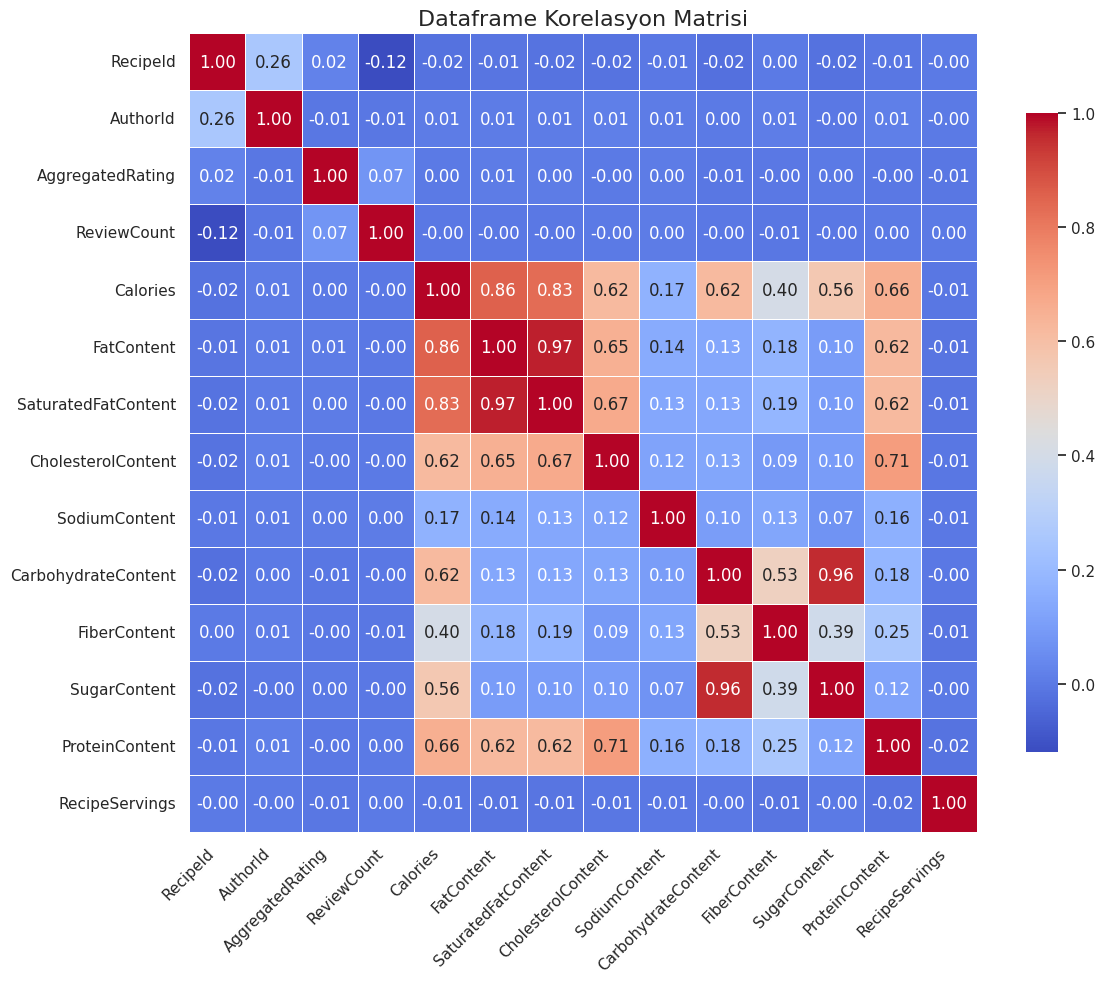

In [51]:
# Sayısal sütunları seçmek
num_cols = df.select_dtypes(include=[np.number])

# Korelasyon matrisini hesapla
corr_matrix = num_cols.corr()

#Korelasyon matrisini yazdır
print(corr_matrix)

# Korelasyon matrisini ısı haritası olarak görselleştir
plt.figure(figsize=(12, 10))  # Grafik boyutunu büyüttük
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})

# Başlık ve etiketleri döndür
plt.title("Dataframe Korelasyon Matrisi", fontsize=16)
plt.xticks(rotation=45, ha="right")  # X eksenindeki etiketleri sağa döndür
plt.yticks(rotation=0)  # Y eksenindeki etiketleri düz tut
plt.tight_layout()  # Eksen etiketlerinin yerinde olmasını sağla
plt.show()

* FatContent, SaturatedFatContent ve CholesterolContent yüksek korelasyona sahip (yaklaşık 0.65 ila 0.97 arası). Bu özellikler birbirine yakın olabilir, bu yüzden bunlardan bir veya birkaçı modelden çıkarılabilir ya da birleşik bir değişken oluşturulabilir.

* SugarContent ile CarbohydrateContent arasında çok güçlü bir korelasyon var (0.96). Bu da şeker içeriği ve karbonhidratların birbirini çok iyi temsil ettiğini gösteriyor. Bu yüzden bu iki özellikten birinin modelde yer alması yeterli olabilir.

* FiberContent ile CarbohydrateContent arasında orta düzeyde (0.53) bir korelasyon var. Bu ikisinin birlikte kullanılması anlamlı olabilir.

**FEATURE ENGINEERING**

In [52]:
recipes_6.head()

,RecipeId,Name,AuthorId,AuthorName,DatePublished,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,CookTime(min),PrepTime(min),TotalTime(min)
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,1999-08-09,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",Frozen Desserts,"c(""Dessert"", ""Low Protein"", ""Low Cholesterol"",...","c(""4"", ""1/4"", ""1"", ""1"")","c(""blueberries"", ""granulated sugar"", ""vanilla ...",4.500,4.000,170.900,2.500,1.300,8.000,29.800,37.100,3.600,30.200,3.200,4.000,"c(""Toss 2 cups berries with sugar."", ""Let stan...",450.000,45.000,642.500
1,39,Biryani,1567,elly9812,1999-08-29,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",Chicken Breast,"c(""Chicken Thigh & Leg"", ""Chicken"", ""Poultry"",...","c(""1"", ""4"", ""2"", ""2"", ""8"", ""1/4"", ""8"", ""1/2"", ...","c(""saffron"", ""milk"", ""hot green chili peppers""...",3.000,1.000,1061.450,58.800,16.600,264.050,368.400,84.400,9.000,20.400,57.250,6.000,"c(""Soak saffron in warm milk for 5 minutes and...",25.000,145.500,265.000
2,40,Best Lemonade,1566,Stephen Little,1999-09-05,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",Beverages,"c(""Low Protein"", ""Low Cholesterol"", ""Healthy"",...","c(""1 1/2"", ""1"", NA, ""1 1/2"", NA, ""3/4"")","c(""sugar"", ""lemons, rind of"", ""lemon, zest of""...",4.500,8.500,311.100,0.200,0.000,0.000,1.800,81.500,0.400,41.000,0.300,4.000,"c(""Into a 1 quart Jar with tight fitting lid, ...",5.000,30.000,35.000
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,1999-09-03,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",Soy/Tofu,"c(""Beans"", ""Vegetable"", ""Low Cholesterol"", ""We...","c(""12"", ""1"", ""2"", ""1"", ""10"", ""1"", ""3"", ""2"", ""2...","c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...",4.500,2.000,536.100,24.000,3.800,0.000,1558.600,64.200,10.300,32.100,29.300,2.000,"c(""Drain the tofu, carefully squeezing out exc...",20.000,145.500,642.500
4,42,Cabbage Soup,1538,Duckie067,1999-09-19,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",Vegetable,"c(""Low Protein"", ""Vegan"", ""Low Cholesterol"", ""...","c(""46"", ""4"", ""1"", ""2"", ""1"")","c(""plain tomato juice"", ""cabbage"", ""onion"", ""c...",4.500,8.500,103.600,0.400,0.100,0.000,959.300,25.100,4.800,17.700,4.300,4.000,"c(""Mix everything together and bring to a boil...",30.000,20.000,50.000


Feature Extraction

In [53]:
recipes_7 = recipes_6.copy()

In [54]:
#toplam yağ içeriği
recipes_7['TotalFat'] = recipes_7['FatContent'] + recipes_7['SaturatedFatContent']

#Düşük kalorili yiyecekler 
recipes_7['LowCalorie'] = recipes_7['Calories'] < 300

#Kısa süreli yemekler
recipes_7['ShortDuration'] = recipes_7['TotalTime(min)'] < 30

#Ketojenik diyetler için yeni Karbonhidrat kolonu oluşturalım
# Karbonhidrat içeriğine göre yemekleri sınıflandıralım
def classify_carbs(carbs):
    if carbs <= 20:
        return 'LowCarb'    # Düşük karbonhidrat
    elif 21 <= carbs <= 50:
        return 'MediumCarb' # Orta karbonhidrat
    else:
        return 'HighCarb'   # Yüksek karbonhidrat

recipes_7['CarbCategory'] = recipes_7['CarbohydrateContent'].apply(classify_carbs)

In [55]:
# Düşük kalorili yemeklerin sayısı

low_calorie_recipes = recipes_7[recipes_7['LowCalorie'] == True]
print(f"Düşük kalorili yemek sayısı: {len(low_calorie_recipes)}")

Düşük kalorili yemek sayısı: 247163


In [56]:
# Kısa süreli yemeklerin sayısı
short_duration_recipes = recipes_6[recipes_7['ShortDuration'] == True]
print(f"Kısa süreli yemek sayısı: {len(short_duration_recipes)}")

Kısa süreli yemek sayısı: 175651


In [57]:
cat_cols, num_cols, cat_but_car = grab_col_names(recipes_7)

print("Categorical column names: {}".format(cat_cols))
print("Numerical column names: {}".format(num_cols))
print("Kardinal column names: {}".format(cat_but_car))

Observations: 522514
Variables: 31
cat_cols: 5
num_cols: 17
cat_but_car: 9
num_but_cat: 4
Categorical column names: ['CarbCategory', 'AggregatedRating', 'ReviewCount', 'LowCalorie', 'ShortDuration']
Numerical column names: ['RecipeId', 'AuthorId', 'DatePublished', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'CookTime(min)', 'PrepTime(min)', 'TotalTime(min)', 'TotalFat']
Kardinal column names: ['Name', 'AuthorName', 'Description', 'Images', 'RecipeCategory', 'Keywords', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeInstructions']


In [58]:
recipes_8 = recipes_7.copy()

İlgilendiğimiz sütunları filtreleyeceğiz. Tariflerin besin özelliklerini alan bir öneri motoru oluşturduğumuz için, ilgili sütunları içeren bir alt veri çıkaracağız. Projemiz için başka sütunlara da ihtiyacımız olabilir. Ancak modelimizi eğitmek için ağırlıklı olarak beslenme bilgisi içeren sütunları kullanacağız.

In [59]:
recipes_8.head()

,RecipeId,Name,AuthorId,AuthorName,DatePublished,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,CookTime(min),PrepTime(min),TotalTime(min),TotalFat,LowCalorie,ShortDuration,CarbCategory
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,1999-08-09,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",Frozen Desserts,"c(""Dessert"", ""Low Protein"", ""Low Cholesterol"",...","c(""4"", ""1/4"", ""1"", ""1"")","c(""blueberries"", ""granulated sugar"", ""vanilla ...",4.500,4.000,170.900,2.500,1.300,8.000,29.800,37.100,3.600,30.200,3.200,4.000,"c(""Toss 2 cups berries with sugar."", ""Let stan...",450.000,45.000,642.500,3.800,True,False,MediumCarb
1,39,Biryani,1567,elly9812,1999-08-29,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",Chicken Breast,"c(""Chicken Thigh & Leg"", ""Chicken"", ""Poultry"",...","c(""1"", ""4"", ""2"", ""2"", ""8"", ""1/4"", ""8"", ""1/2"", ...","c(""saffron"", ""milk"", ""hot green chili peppers""...",3.000,1.000,1061.450,58.800,16.600,264.050,368.400,84.400,9.000,20.400,57.250,6.000,"c(""Soak saffron in warm milk for 5 minutes and...",25.000,145.500,265.000,75.400,False,False,HighCarb
2,40,Best Lemonade,1566,Stephen Little,1999-09-05,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",Beverages,"c(""Low Protein"", ""Low Cholesterol"", ""Healthy"",...","c(""1 1/2"", ""1"", NA, ""1 1/2"", NA, ""3/4"")","c(""sugar"", ""lemons, rind of"", ""lemon, zest of""...",4.500,8.500,311.100,0.200,0.000,0.000,1.800,81.500,0.400,41.000,0.300,4.000,"c(""Into a 1 quart Jar with tight fitting lid, ...",5.000,30.000,35.000,0.200,False,False,HighCarb
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,1999-09-03,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",Soy/Tofu,"c(""Beans"", ""Vegetable"", ""Low Cholesterol"", ""We...","c(""12"", ""1"", ""2"", ""1"", ""10"", ""1"", ""3"", ""2"", ""2...","c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...",4.500,2.000,536.100,24.000,3.800,0.000,1558.600,64.200,10.300,32.100,29.300,2.000,"c(""Drain the tofu, carefully squeezing out exc...",20.000,145.500,642.500,27.800,False,False,HighCarb
4,42,Cabbage Soup,1538,Duckie067,1999-09-19,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",Vegetable,"c(""Low Protein"", ""Vegan"", ""Low Cholesterol"", ""...","c(""46"", ""4"", ""1"", ""2"", ""1"")","c(""plain tomato juice"", ""cabbage"", ""onion"", ""c...",4.500,8.500,103.600,0.400,0.100,0.000,959.300,25.100,4.800,17.700,4.300,4.000,"c(""Mix everything together and bring to a boil...",30.000,20.000,50.000,0.500,True,False,MediumCarb


In [60]:
recipes_8.info()

<class 'pandas.core.frame.DataFrame'>
Index: 522514 entries, 0 to 522516
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   RecipeId                    522514 non-null  int64         
 1   Name                        522514 non-null  object        
 2   AuthorId                    522514 non-null  int64         
 3   AuthorName                  522514 non-null  object        
 4   DatePublished               522514 non-null  datetime64[ns]
 5   Description                 522514 non-null  object        
 6   Images                      522514 non-null  object        
 7   RecipeCategory              522514 non-null  object        
 8   Keywords                    522514 non-null  object        
 9   RecipeIngredientQuantities  522514 non-null  object        
 10  RecipeIngredientParts       522514 non-null  object        
 11  AggregatedRating            522514 non-null 

In [61]:
columns=['RecipeId','Name','CookTime(min)','PrepTime(min)','TotalTime(min)','RecipeIngredientParts','Calories','FatContent','SaturatedFatContent','CholesterolContent','SodiumContent','CarbohydrateContent','FiberContent','SugarContent','ProteinContent','RecipeInstructions','TotalFat','LowCalorie','ShortDuration','CarbCategory']
dataset=recipes_8[columns]

In [62]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 522514 entries, 0 to 522516
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   RecipeId               522514 non-null  int64  
 1   Name                   522514 non-null  object 
 2   CookTime(min)          522514 non-null  float64
 3   PrepTime(min)          522514 non-null  float64
 4   TotalTime(min)         522514 non-null  float64
 5   RecipeIngredientParts  522514 non-null  object 
 6   Calories               522514 non-null  float64
 7   FatContent             522514 non-null  float64
 8   SaturatedFatContent    522514 non-null  float64
 9   CholesterolContent     522514 non-null  float64
 10  SodiumContent          522514 non-null  float64
 11  CarbohydrateContent    522514 non-null  float64
 12  FiberContent           522514 non-null  float64
 13  SugarContent           522514 non-null  float64
 14  ProteinContent         522514 non-null  f

In [63]:
max_Calories=2000
max_daily_fat=100
max_daily_Saturatedfat=13
max_daily_Cholesterol=300
max_daily_Sodium=2300
max_daily_Carbohydrate=325
max_daily_Fiber=40
max_daily_Sugar=40
max_daily_Protein=200
max_list=[max_Calories,max_daily_fat,max_daily_Saturatedfat,max_daily_Cholesterol,max_daily_Sodium,max_daily_Carbohydrate,max_daily_Fiber,max_daily_Sugar,max_daily_Protein]

In [64]:
extracted_data=dataset.copy()
for column,maximum in zip(extracted_data.columns[6:15],max_list):
    extracted_data=extracted_data[extracted_data[column]<maximum]

In [65]:
extracted_data['Calories'].describe()

count   388898.000
mean       277.770
std        188.352
min          0.000
25%        139.900
50%        243.000
75%        374.200
max       1061.450
Name: Calories, dtype: float64

In [66]:
dataset['Calories'].describe()

count   522514.000
mean       390.644
std        285.651
min          0.000
25%        174.200
50%        317.100
75%        529.100
max       1061.450
Name: Calories, dtype: float64

SCALING

In [67]:
scaler=StandardScaler()
prep_data=scaler.fit_transform(extracted_data.iloc[:,6:15].to_numpy())

In [68]:
prep_data

array([[-0.56739754, -0.93029637, -0.78827744, ...,  0.26304236,
         2.34625594, -0.7136375 ],
       [ 1.37153121,  1.10020403, -0.07863157, ...,  2.63225714,
         2.55397073,  1.22085603],
       [-0.92470834, -1.12862431, -1.12890745, ...,  0.68737933,
         0.97971127, -0.63210712],
       ...,
       [ 0.43073665,  0.70354814,  1.82321934, ..., -0.72707725,
         1.75590864, -0.59504785],
       [ 0.20615645,  0.01412242,  1.00003014, ..., -0.72707725,
         1.5372615 , -0.66175453],
       [-1.38926548, -1.10973594, -1.12890745, ..., -1.00996857,
        -0.94438363, -0.77293232]])

In [69]:
user_ingredients = {"egg", "flour", "milk"}  # küme olması hız için avantajlı
def top_f1_recipes(df, user_ingredients, top_n=10):
    results = []

    for _, row in df.iterrows():
        ingredients = [ing.lower() for ing in row["RecipeIngredientParts"]]
        matched = []

        for user_ing in user_ingredients:
            if any(user_ing in ing for ing in ingredients):
                matched.append(user_ing)

        score = len(matched)
        if score == 0:
            continue

        precision = score / len(ingredients) if ingredients else 0
        recall = score / len(user_ingredients) if user_ingredients else 0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) else 0

        results.append({
            "Name": row["Name"],
            "MatchedIngredients": matched,
            "Score": score,
            "Precision": round(precision, 3),
            "Recall": round(recall, 3),
            "F1": round(f1_score, 3),
            "AllIngredients": ingredients
        })

    if not results:
        return pd.DataFrame()

    # F1'e göre sırala ve sadece en iyi n tanesini döndür
    return pd.DataFrame(results).sort_values("F1", ascending=False).head(top_n)

In [70]:
extracted_data['RecipeIngredientParts'].head()
import re

def parse_r_c_style_list(text):
    if not isinstance(text, str) or not text.startswith("c("):
        return []
    # R formatında c("item1", "item2", ...) → Python listesine çevir
    return re.findall(r'"(.*?)"', text)
extracted_data_1 = extracted_data.copy()
extracted_data_1["RecipeIngredientParts"] = extracted_data_1["RecipeIngredientParts"].apply(parse_r_c_style_list)

# En iyi 10 tarif
top_matches = top_f1_recipes(extracted_data_1, user_ingredients)

# Göster
print(top_matches[["Name", "MatchedIngredients", "Score", "Precision", "Recall", "F1"]])

                                                     Name  MatchedIngredients  Score  Precision  Recall    F1
127514             As Easy As It Gets Chicken-Fried Steak  [milk, flour, egg]      3      1.000   1.000 1.000
139242  Simply Potatoes Diced Potatoes W/Onion-Sausage...  [milk, flour, egg]      3      1.000   1.000 1.000
48534                                           Corn Dogs  [milk, flour, egg]      3      1.000   1.000 1.000
144261             Sour Cream and Chive Potato Cakes #SP5  [milk, flour, egg]      3      1.000   1.000 1.000
49416                       Whole Wheat  Swedish Pancakes  [milk, flour, egg]      3      1.000   1.000 1.000
125885                          Jamezies' German Pancakes  [milk, flour, egg]      3      1.000   1.000 1.000
68578                                  Chicken Fried Spam  [milk, flour, egg]      3      1.000   1.000 1.000
27218                                         Spam Sticks  [milk, flour, egg]      3      1.000   1.000 1.000
122628    

MODELING

In [71]:
X = extracted_data.iloc[:, 6:15]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Üsttekinin streamlit entegrasyon kodu;

if user_ingredients:
    top_matches = top_f1_recipes(recipes_6, user_ingredients)

    if not top_matches.empty:
        st.dataframe(top_matches[["Name", "MatchedIngredients", "Score", "Precision", "Recall", "F1"]])
    else:
        st.warning("Uygun tarif bulunamadı. Daha genel malzemeler deneyin.")

MODELING

In [72]:
X = extracted_data.iloc[:, 6:15]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ELBOW YÖNTEMİ

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

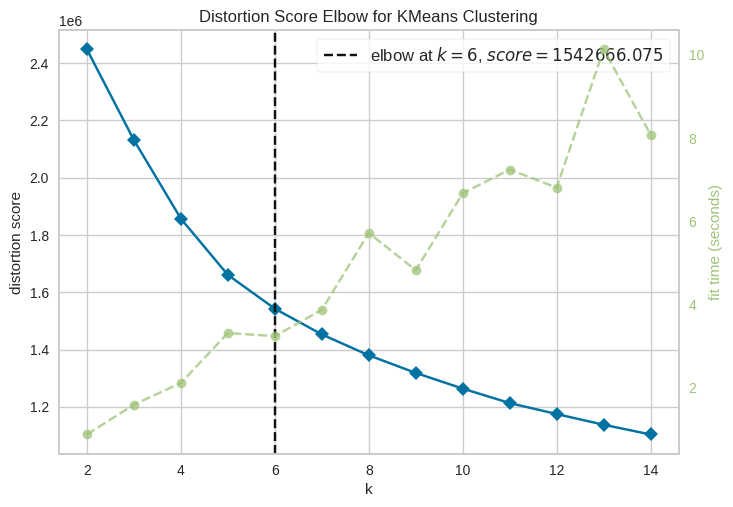

Optimal küme sayısı: 6


In [73]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

kmeans = KMeans(random_state=42)
elbow = KElbowVisualizer(kmeans, k=(2,15))
elbow.fit(X_scaled)
elbow.show(block=True)

# En uygun küme sayısını al
optimal_k = elbow.elbow_value_
print(f"Optimal küme sayısı: {optimal_k}")

Modeli Kuralım

In [74]:
# Elbow'dan gelen küme sayısı
optimal_k = elbow.elbow_value_

# K-Means modelini kur ve eğit
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Küme numarasını veri setine ekle
extracted_data['Cluster'] = clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [75]:
 extracted_data['Cluster'] = clusters + 1

Küme başına düşen tarif sayısına bakalım

In [76]:
print(extracted_data['Cluster'].value_counts().sort_index())

Cluster
1     50383
2     43969
3    135282
4     79489
5     52241
6     27534
Name: count, dtype: int64


Oluşturduğumuz kümelerin ortalama besin değerlerine bakalım

In [77]:
cluster_summary = extracted_data.groupby("Cluster").mean(numeric_only=True)
print(cluster_summary)

          RecipeId  CookTime(min)  PrepTime(min)  TotalTime(min)  Calories  FatContent  SaturatedFatContent  CholesterolContent  SodiumContent  CarbohydrateContent  FiberContent  SugarContent  ProteinContent  TotalFat  LowCalorie  ShortDuration
Cluster                                                                                                                                                                                                                                             
1       286365.964         50.115         18.707          74.043   329.274       9.886                2.418              20.422        573.537               48.030         7.078         7.574          13.983    12.304       0.426          0.302
2       274567.213         57.956         20.837          86.404   464.947      24.696                8.029             150.686        827.061               23.640         2.286         5.955          33.794    32.725       0.058          0.237
3       273507.272  

Görselleştirelim

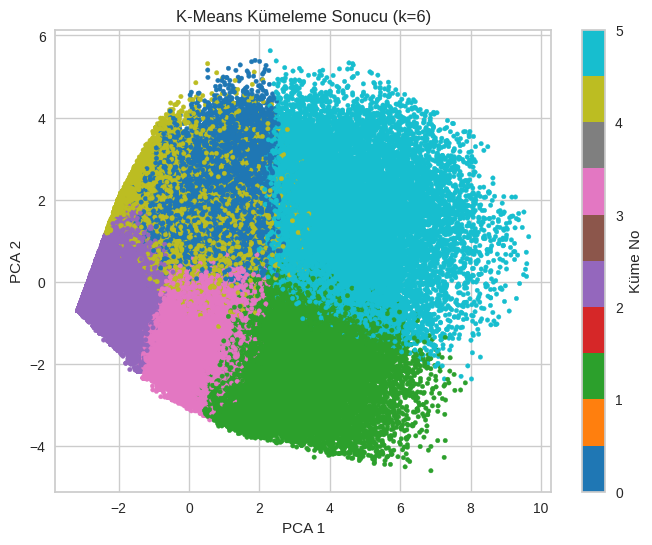

In [78]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='tab10', s=10)
plt.title(f'K-Means Kümeleme Sonucu (k={optimal_k})')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Küme No')
plt.grid(True)
plt.show()

In [79]:
X = extracted_data.iloc[:, 6:15]  # beslenme özellikleri
y = extracted_data['Cluster']     # KMeans kümeleri

# Eğitim ve test setine ayırdık
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# KNN modelini kurduk
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Tahmin
y_pred = knn.predict(X_test)

# Değerlendirme
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8804705579840576
Confusion Matrix:
 [[ 7480   140   801  1246   273   161]
 [   53  7918     0   346    22   445]
 [  516     0 25743   589   236     0]
 [  943   376   597 13486   237    43]
 [  482    94   398   304  9152    57]
 [  187   645     0    64    42  4704]]
Classification Report:
               precision    recall  f1-score   support

           1       0.77      0.74      0.76     10101
           2       0.86      0.90      0.88      8784
           3       0.93      0.95      0.94     27084
           4       0.84      0.86      0.85     15682
           5       0.92      0.87      0.90     10487
           6       0.87      0.83      0.85      5642

    accuracy                           0.88     77780
   macro avg       0.87      0.86      0.86     77780
weighted avg       0.88      0.88      0.88     77780



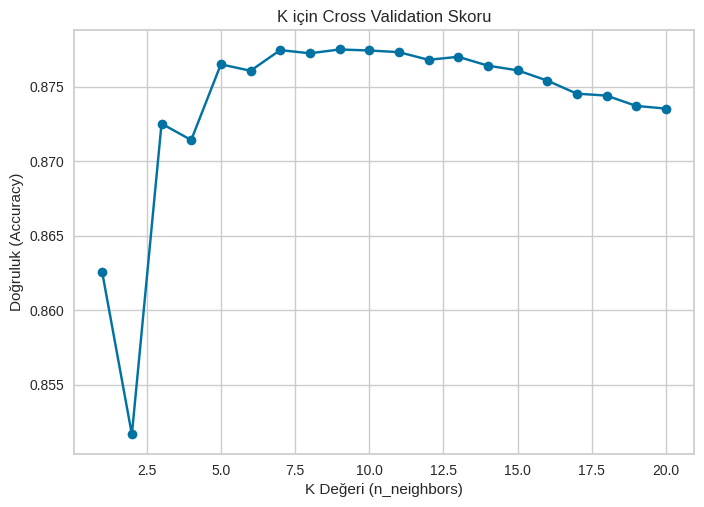

In [80]:
k_values = range(1, 21)
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, y_train, cv=5).mean()
    scores.append(score)

plt.plot(k_values, scores, marker='o')
plt.xlabel('K Değeri (n_neighbors)')
plt.ylabel('Doğruluk (Accuracy)')
plt.title('K için Cross Validation Skoru')
plt.grid(True)
plt.show()

In [81]:
# Özellikler ve hedef
X = extracted_data.iloc[:, 6:15]  # beslenme sütunları
y = extracted_data['Cluster']     # hedef: küme numarası

# Veriyi eğitim ve test olarak ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeli oluştur ve eğit
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Tahmin yap
y_pred = rf_model.predict(X_test)

# Performans ölçümleri
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9744535870403703
Confusion Matrix:
 [[ 9725    16    90   140    46    84]
 [   22  8433     0   201    16   112]
 [   74     0 26785   177    48     0]
 [   90   162   185 15180    50    15]
 [   51    20    77    67 10253    19]
 [   91   109     0    11    14  5417]]
Classification Report:
               precision    recall  f1-score   support

           1       0.97      0.96      0.97     10101
           2       0.96      0.96      0.96      8784
           3       0.99      0.99      0.99     27084
           4       0.96      0.97      0.97     15682
           5       0.98      0.98      0.98     10487
           6       0.96      0.96      0.96      5642

    accuracy                           0.97     77780
   macro avg       0.97      0.97      0.97     77780
weighted avg       0.97      0.97      0.97     77780




Özellik Önem Değerleri:

               Özellik  Önem
0             Calories 0.230
7         SugarContent 0.143
6         FiberContent 0.118
3   CholesterolContent 0.112
8       ProteinContent 0.103
5  CarbohydrateContent 0.098
1           FatContent 0.094
2  SaturatedFatContent 0.057
4        SodiumContent 0.046


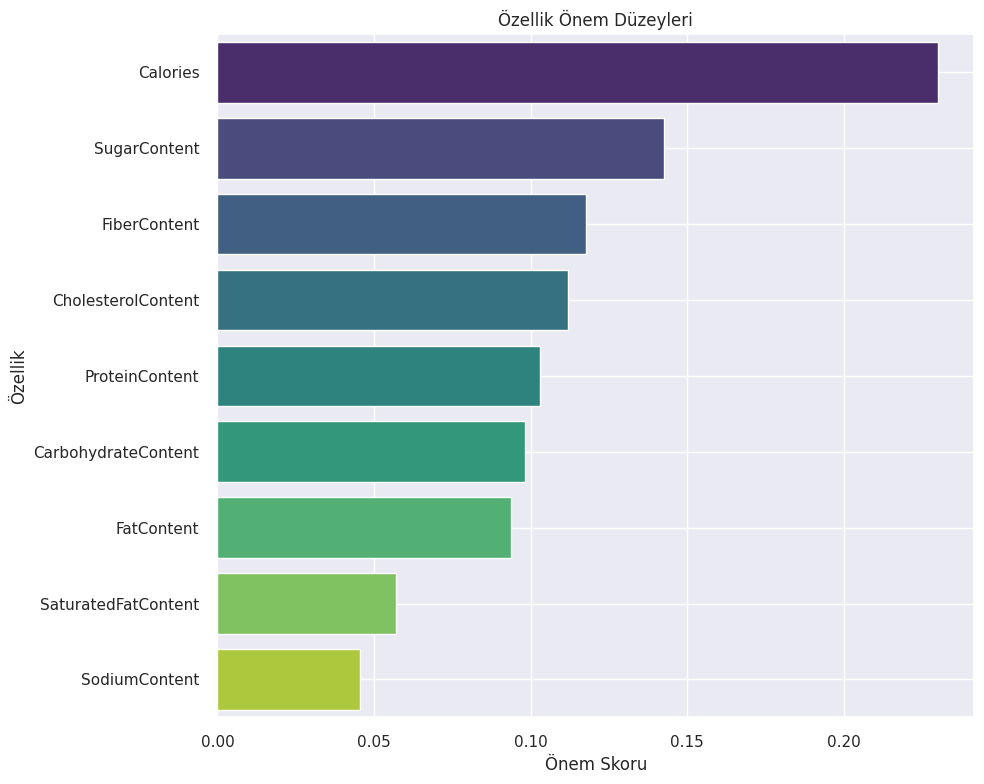

In [82]:
def plot_feature_importance(model, X, num=None, save=False, filename="feature_importance.png"):
    """
    Verilen modelin özellik önemlerini görselleştirir ve yazdırır.

    Parameters:
    - model: Eğitilmiş bir model (RandomForest, XGBoost vb.)
    - X: Özellikleri içeren DataFrame
    - num: Kaç özelliğin gösterileceği (Varsayılan: tümü)
    - save: Görseli dosya olarak kaydetmek istersen True yap
    - filename: Kaydedilecek dosya ismi (varsayılan: 'feature_importance.png')
    """

    if num is None:
        num = len(X.columns)


    importances = model.feature_importances_
    feature_names = X.columns

    # DataFrame oluşturduk
    importance_df = pd.DataFrame({
        'Özellik': feature_names,
        'Önem': importances
    }).sort_values(by='Önem', ascending=False)

    print("\nÖzellik Önem Değerleri:\n")
    print(importance_df)

    # Görselleştirme
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1)
    sns.barplot(x='Önem', y='Özellik', data=importance_df.head(num), palette='viridis')
    plt.title("Özellik Önem Düzeyleri")
    plt.xlabel("Önem Skoru")
    plt.ylabel("Özellik")
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(filename)

    plt.show()

plot_feature_importance(rf_model, X, num=10, save=False)

In [83]:
extracted_data.to_csv('extracted_data.csv', index=False)

# ZIP'e al
import zipfile
with zipfile.ZipFile('extracted_data.zip', 'w') as zipf:
    zipf.write('extracted_data.csv')


In [84]:
import os
os.listdir('/kaggle/working/')


['extracted_data.csv', '__notebook__.ipynb', 'extracted_data.zip']